In [1]:
import pandas as pd

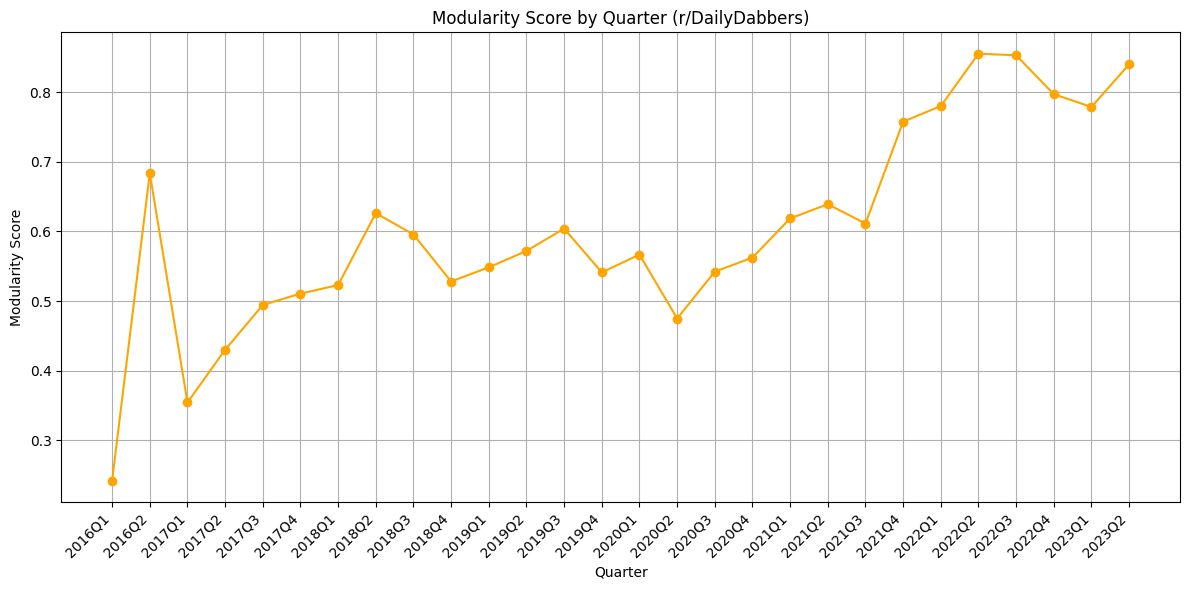

In [2]:
import pandas as pd
import networkx as nx
from community import community_louvain, modularity
import matplotlib.pyplot as plt

# Load your full DailyDabbers dataset
csv_path = r"/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/Combined Daily Dabbers W Network/r_dailydabbers_network.csv"
df = pd.read_csv(csv_path)

# Convert time and prepare for grouping
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Store modularity scores
modularity_scores = []

for period, group in df.groupby('quarter'):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)
            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)

    if len(G.nodes) < 10:
        continue

    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    mod_score = modularity(partition, undirected_G)

    modularity_scores.append((str(period), mod_score))

# Create DataFrame
mod_df = pd.DataFrame(modularity_scores, columns=["Quarter", "Modularity Score"])

# Filter to quarters <= 2023Q2
mod_df['Quarter'] = mod_df['Quarter'].astype(str)
mod_df_filtered = mod_df[mod_df['Quarter'] <= '2023Q2']

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(mod_df_filtered['Quarter'], mod_df_filtered['Modularity Score'], marker='o', linestyle='-', color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Modularity Score by Quarter (r/DailyDabbers)")
plt.xlabel("Quarter")
plt.ylabel("Modularity Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import networkx as nx

# Load r/DailyDabbers network dataset
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/Combined Daily Dabbers W Network/r_dailydabbers_network.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Define epochs
epoch_ranges = {
    "E0_Seed": ["2012Q1", "2016Q4"],
    "E1_Takeoff": ["2017Q1", "2019Q4"],
    "E2_PandemicBoom": ["2020Q1", "2021Q4"],
    "E3_PostPeak": ["2022Q1", "2023Q4"]
}

top_users = []

for label, (start_q, end_q) in epoch_ranges.items():
    slice_df = df[(df["quarter"] >= start_q) & (df["quarter"] <= end_q)]

    G = nx.DiGraph()
    for _, row in slice_df.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)

            # Skip deleted/removed accounts
            if author in ["[deleted]", "[removed]"] or parent_author in ["[deleted]", "[removed]"]:
                continue

            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)

    if len(G) == 0:
        continue

    pr = nx.pagerank(G)
    top_25 = sorted(pr.items(), key=lambda x: x[1], reverse=True)

    # Filter out deleted/removed before saving
    clean_top_25 = [
        {"Epoch": label, "Author": user}
        for user, _ in top_25
        if user not in ["[deleted]", "[removed]"]
    ][:25]

    top_users.extend(clean_top_25)

# Save to CSV
top_users_df = pd.DataFrame(top_users)
output_path = "/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_users.csv"
top_users_df.to_csv(output_path, index=False)
print(f"✅ Saved top influential users CSV to: {output_path}")


/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_users.csv


✅ Saved top influential users CSV to: /Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_users.csv


In [5]:
import pandas as pd
import networkx as nx
from community import community_louvain, modularity
from collections import Counter

# Load network data
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/Combined Daily Dabbers W Network/r_dailydabbers_network.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Load top users
top_users_df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_users.csv")
top_users_by_epoch = top_users_df.groupby("Epoch")["Author"].apply(set).to_dict()

# Define epochs (formatted like r/Dabs version)
epoch_ranges = {
    "E0_Seed": ["2015Q1", "2016Q4"],
    "E1_Takeoff": ["2017Q1", "2019Q1"],
    "E2_PandemicBoom": ["2019Q2", "2021Q4"],
    "E3_PostPeak": ["2022Q1", "2023Q2"]
}

# Store results
modularity_scores = []
edge_rows = []
full_rows = []

for label, (start_q, end_q) in epoch_ranges.items():
    if label not in top_users_by_epoch:
        print(f"⚠️ Skipping {label}: no top users provided")
        continue

    top_users = top_users_by_epoch[label]
    slice_df = df[(df["quarter"] >= start_q) & (df["quarter"] <= end_q)]

    G = nx.DiGraph()
    for _, row in slice_df.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)
            if (
                parent_author and parent_author != author
                and author in top_users
                and parent_author in top_users
            ):
                G.add_edge(author, parent_author)

    if len(G.nodes) < 10:
        print(f"⚠️ Skipping {label}: too few top-user interactions")
        continue

    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    mod_score = modularity(partition, undirected_G)
    sizes = Counter(partition.values())

    modularity_scores.append({
        "Epoch": label,
        "Nodes": len(G),
        "Edges": G.number_of_edges(),
        "Communities": len(sizes),
        "Avg Community Size": round(sum(sizes.values()) / len(sizes), 2),
        "Modularity Score": round(mod_score, 4),
        "Largest Community": max(sizes.values())
    })

    # Collect edge list and usernames involved
    edge_users = set()
    for u, v in G.edges():
        edge_rows.append({"Epoch": label, "Source": u, "Target": v})
        edge_users.update([u, v])

    # Pull all original rows authored by top-user participants
    matching_rows = slice_df[slice_df["author"].isin(edge_users)].copy()
    matching_rows["Epoch"] = label
    full_rows.append(matching_rows)

# Output modularity scores
mod_df = pd.DataFrame(modularity_scores)
print(mod_df)

# Export edges
edges_df = pd.DataFrame(edge_rows)
edges_df.to_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_threads.csv", index=False)

# Export full user rows
full_df = pd.concat(full_rows, ignore_index=True)
full_df.to_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:DailyDabbers/top_influential_full_data.csv", index=False)

print("✅ Exported full influential user rows and thread connections.")


             Epoch  Nodes  Edges  Communities  Avg Community Size  \
0          E0_Seed     25     57            5                 5.0   
1       E1_Takeoff     22    206            2                11.0   
2  E2_PandemicBoom     23     63            5                 4.6   
3      E3_PostPeak     15     16            5                 3.0   

   Modularity Score  Largest Community  
0            0.3616                  7  
1            0.1255                 11  
2            0.2962                  6  
3            0.7200                  5  
✅ Exported full influential user rows and thread connections.
